In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding

import time
start_time = time.time()

print("started")

started


In [2]:
# dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"
datasets_path = r"/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets"

datasets = []
dataset_path = []

i = 0
for filename in os.listdir(datasets_path):
    if i>2:
        break
    file_path = os.path.join(datasets_path, filename)
    dataset_path.append(file_path)

dataset_path = sorted(dataset_path)

for path in dataset_path:
    print(path)

for file in dataset_path:
    if os.path.isfile(file):  # Check if it's a file
        print(f"Processing file: {file}")
        hsi = HSI(file)
        datasets.append(hsi)
    i += 1

/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/.ipynb_checkpoints
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM01.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM02.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM03.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM04.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM05.mat
/home/wijayanti/Desktop/FathanAbi/TA/tugas-akhir-model-deteksi-tumpahan-minyakl/Dataset/Hyperspectral oil spill detection datasets/GM06.mat
/home/wija

In [4]:
print(datasets[0].name)

GM01


In [5]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 5000

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [6]:
def predict_batch(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    predicted_classes = model.predict(test_features_np)
    probs = model.predict_proba(test_features_np)
    positive_probs = probs[:, 1]  # probability of class 1


    return predicted_classes, positive_probs


In [7]:
import createSample as CS

hsi_ = datasets[0]
patch_size = 9
sample_per_class = 50

indices_0 = []
indices_1 = []
random = 0
print(f"random: {random}")

if random:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(526), np.int64(187)), (np.int64(537), np.int64(71)), (np.int64(496), np.int64(222)), (np.int64(1200), np.int64(102)), (np.int64(1178), np.int64(413))]
    indices_1 = [(np.int64(174), np.int64(66)), (np.int64(382), np.int64(580)), (np.int64(1202), np.int64(171)), (np.int64(469), np.int64(254)), (np.int64(267), np.int64(228))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2
# print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
# print(selected_patch_0[i][half_patch][half_patch])

# print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
# print(selected_patch_1[i][half_patch][half_patch])
# i =4
# half_patch = patch_size // 2
# print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
# print(selected_patch_0[i][half_patch][half_patch])

# print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
# print(selected_patch_1[i][half_patch][half_patch])

indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
using generated indices
hsi shape
(1243, 684, 224)
indices 0 used: [(np.int64(526), np.int64(187)), (np.int64(537), np.int64(71)), (np.int64(496), np.int64(222)), (np.int64(1200), np.int64(102)), (np.int64(1178), np.int64(413))]
indices 1 used: [(np.int64(174), np.int64(66)), (np.int64(382), np.int64(580)), (np.int64(1202), np.int64(171)), (np.int64(469), np.int64(254)), (np.int64(267), np.int64(228))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [8]:
import augmentation as aug
n_category = 2
band_size = 224
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

# # Count occurrences of each unique element
# counts1 = np.bincount(label_augment1)

# # Print results
# for i, count in enumerate(counts1):
#     print(f"Element {i} occurs {count} times.")

# counts2 = np.bincount(label_augment2)

# # Print results
# for i, count in enumerate(counts2):
#     print(f"Element {i} occurs {count} times.")

# print(label_augment1[3])

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [9]:
# import torch
# import torch.nn as nn
import torch.nn.functional as F

class ConvTo1D(nn.Module):
    def __init__(self):
        super(ConvTo1D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
        self.flatten = nn.Flatten()               # (batch_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x

feature_extractor = ConvTo1D()

In [10]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

feature_extractor = ConvTo1D()
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(x_data)  # (100, 128)
    features_np = features.numpy() 

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 128)


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

print(y_train)
print(y_val)

[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- Train SVM with probability enabled ---
pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
pipeline.fit(X_train, y_train)

# --- Evaluate on validation set ---
predicted_classes = pipeline.predict(X_val)
probs = pipeline.predict_proba(X_val)
positive_probs = probs[:, 1]  # probability of class 1

# Combine both into a display
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# y_pred = svm.predict(X_val)
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")

# print("Classification Report:")
# print(classification_report(y_val, y_pred))

# print(y_pred)

Sample 0: Predicted = 1, Prob(class 1) = 0.9843
Sample 1: Predicted = 1, Prob(class 1) = 0.8353
Sample 2: Predicted = 1, Prob(class 1) = 0.7709
Sample 3: Predicted = 0, Prob(class 1) = 0.3657
Sample 4: Predicted = 0, Prob(class 1) = 0.0767
Sample 5: Predicted = 1, Prob(class 1) = 0.9167
Sample 6: Predicted = 1, Prob(class 1) = 0.8353
Sample 7: Predicted = 0, Prob(class 1) = 0.2941
Sample 8: Predicted = 1, Prob(class 1) = 0.9745
Sample 9: Predicted = 0, Prob(class 1) = 0.3173
Sample 10: Predicted = 0, Prob(class 1) = 0.0564
Sample 11: Predicted = 0, Prob(class 1) = 0.1031
Sample 12: Predicted = 1, Prob(class 1) = 0.8971
Sample 13: Predicted = 1, Prob(class 1) = 0.8382
Sample 14: Predicted = 1, Prob(class 1) = 0.8352
Sample 15: Predicted = 0, Prob(class 1) = 0.1105
Sample 16: Predicted = 1, Prob(class 1) = 0.8659
Sample 17: Predicted = 0, Prob(class 1) = 0.0575
Sample 18: Predicted = 0, Prob(class 1) = 0.1733
Sample 19: Predicted = 1, Prob(class 1) = 0.9199
Validation Accuracy: 1.0000


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

patch_size = 9
half_patch = patch_size // 2

scores = []
batch_size = 64
groundtruth = []
prediction = []
y_probs = []


for dataset in range(len(datasets)):
    print(f"tes: {dataset}")
    test_indices, test_gt, matrix = testWithDataset(dataset)

    total = len(test_indices)
    correct0 = 0
    correct1 = 0

    input_patches = []
    true_labels = []

    # Prepare all patches
    for x_pos, y_pos in test_indices:
        true_label = test_gt[x_pos][y_pos]

        selected_rows = matrix[x_pos:x_pos + 2*half_patch + 1, :]
        testing_patch = selected_rows[:, y_pos:y_pos + 2*half_patch + 1]

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

        input_patches.append(patch_tensor)
        true_labels.append(true_label)

    input_patches = torch.cat(input_patches, dim=0)  # Shape: (N, C, H, W)
    true_labels = torch.tensor(true_labels)

    # Process in batches
    for i in tqdm(range(0, total, batch_size), desc="Predicting"):
        batch = input_patches[i:i+batch_size]
        labels = true_labels[i:i+batch_size]

        groundtruth.append(labels)

        preds, postive_class_probs = predict_batch(pipeline, feature_extractor, batch, device)

        prediction.append(preds)
        y_probs.append(postive_class_probs)

        for j in range(len(preds)):
            index = i + j
            # print(f"{index+1}: prediction = {preds[j]}, expected: {labels[j].item()}")
            if preds[j] == labels[j].item():
                if labels[j].item() == 0:
                    correct0 += 1
                elif labels[j] == 1:
                    correct1 += 1

    correct = correct0 + correct1
    print(f"Score: {correct}/{total}")
    
    score = {
        'dataset': dataset,
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    scores.append(score)
    # scores.append((f"dataset{dataset}", f'{correct0}/{total/2}', f'{correct1}/{total/2}', f'{correct}/{total}'))

tes: 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 427.15it/s]


Score: 8066/10000
tes: 1
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 396.73it/s]


Score: 3023/10000
tes: 2
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 300.85it/s]


Score: 7032/10000
tes: 3
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 301.77it/s]


Score: 6330/10000
tes: 4
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 303.77it/s]


Score: 6210/10000
tes: 5
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 420.39it/s]


Score: 7990/10000
tes: 6
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 417.48it/s]


Score: 8154/10000
tes: 7
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 419.41it/s]


Score: 8971/10000
tes: 8
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 416.53it/s]


Score: 6820/10000
tes: 9
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 320.50it/s]


Score: 6482/10000
tes: 10
img shape: (1185, 682, 224)
img shape after padding (1193, 690, 224)
number of pixel 808170
ground truth shape: (1185, 682)
indices = 0 shape: (770065, 2)
indices = 1 shape: (38105, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 313.77it/s]


Score: 6450/10000
tes: 11
img shape: (842, 640, 224)
img shape after padding (850, 648, 224)
number of pixel 538880
ground truth shape: (842, 640)
indices = 0 shape: (521713, 2)
indices = 1 shape: (17167, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 311.82it/s]


Score: 4287/10000
tes: 12
img shape: (836, 572, 224)
img shape after padding (844, 580, 224)
number of pixel 478192
ground truth shape: (836, 572)
indices = 0 shape: (439255, 2)
indices = 1 shape: (38937, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 286.49it/s]


Score: 9368/10000
tes: 13
img shape: (1342, 527, 224)
img shape after padding (1350, 535, 224)
number of pixel 707234
ground truth shape: (1342, 527)
indices = 0 shape: (660450, 2)
indices = 1 shape: (46784, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 286.71it/s]


Score: 8149/10000
tes: 14
img shape: (1260, 523, 224)
img shape after padding (1268, 531, 224)
number of pixel 658980
ground truth shape: (1260, 523)
indices = 0 shape: (633355, 2)
indices = 1 shape: (25625, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 300.66it/s]


Score: 4920/10000
tes: 15
img shape: (1033, 437, 224)
img shape after padding (1041, 445, 224)
number of pixel 451421
ground truth shape: (1033, 437)
indices = 0 shape: (429484, 2)
indices = 1 shape: (21937, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 293.60it/s]


Score: 4976/10000
tes: 16
img shape: (600, 400, 224)
img shape after padding (608, 408, 224)
number of pixel 240000
ground truth shape: (600, 400)
indices = 0 shape: (185193, 2)
indices = 1 shape: (54807, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 303.05it/s]


Score: 8323/10000
tes: 17
img shape: (1175, 563, 224)
img shape after padding (1183, 571, 224)
number of pixel 661525
ground truth shape: (1175, 563)
indices = 0 shape: (587602, 2)
indices = 1 shape: (73923, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 284.22it/s]

Score: 9566/10000


In [18]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{total/2}\t', f'{correct1}/{total/2}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1


print(f"total: \t\t {all_correct0}/{all_total/2} \t {all_correct1}/{all_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

dataset: 0	 4014/5000.0	 4052/5000.0	 8066/10000	
dataset: 1	 627/5000.0	 2396/5000.0	 3023/10000	
dataset: 2	 3103/5000.0	 3929/5000.0	 7032/10000	
dataset: 3	 3001/5000.0	 3329/5000.0	 6330/10000	
dataset: 4	 3074/5000.0	 3136/5000.0	 6210/10000	
dataset: 5	 3964/5000.0	 4026/5000.0	 7990/10000	
dataset: 6	 3212/5000.0	 4942/5000.0	 8154/10000	
dataset: 7	 4779/5000.0	 4192/5000.0	 8971/10000	
dataset: 8	 1859/5000.0	 4961/5000.0	 6820/10000	
dataset: 9	 4894/5000.0	 1588/5000.0	 6482/10000	
dataset: 10	 4861/5000.0	 1589/5000.0	 6450/10000	
dataset: 11	 1725/5000.0	 2562/5000.0	 4287/10000	
dataset: 12	 4450/5000.0	 4918/5000.0	 9368/10000	
dataset: 13	 3192/5000.0	 4957/5000.0	 8149/10000	
dataset: 14	 93/5000.0	 4827/5000.0	 4920/10000	
dataset: 15	 97/5000.0	 4879/5000.0	 4976/10000	
dataset: 16	 4935/5000.0	 3388/5000.0	 8323/10000	
dataset: 17	 4622/5000.0	 4944/5000.0	 9566/10000	
dataset: Total Dataset	 56502/90000.0	 68615/90000.0	 125117/180000	
total: 		 113004/180000.0 	 

In [19]:
groundtruths = groundtruth
groundtruth = []

for x in groundtruths:
    for y in x:
        groundtruth.append(y)

predictions = prediction
prediction = []

for x in predictions:
    for y in x:
        prediction.append(y)


y_prob = []

for x in y_probs:
    for y in x:
        y_prob.append(y)

In [20]:
print(len(groundtruth))
print(len(prediction))
print(len(y_prob))

180000
180000
180000


In [21]:
y_test = groundtruth
y_pred = prediction
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [22]:
print(f'{correct}/{total}')

125117/180000


In [23]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


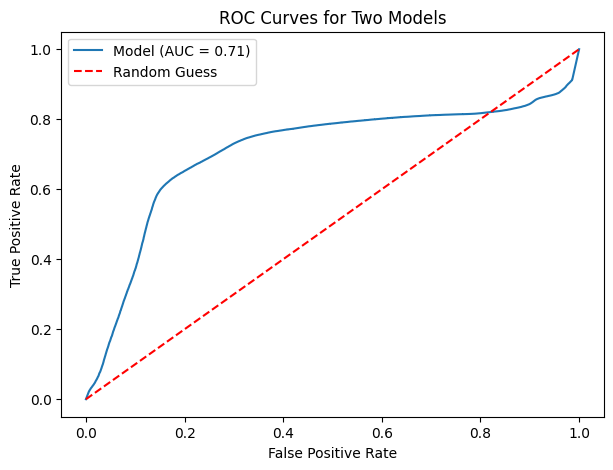

In [24]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [25]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction                          # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.6987
Recall:    0.6951
F1 Score:  0.6937
OA:        0.6951
AA:        0.6951


In [26]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [27]:
import json
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/svm {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'correct_0': 4014, 'correct_1': 4052, 'correct_total': 8066, 'total': 10000}, {'dataset': 1, 'correct_0': 627, 'correct_1': 2396, 'correct_total': 3023, 'total': 10000}, {'dataset': 2, 'correct_0': 3103, 'correct_1': 3929, 'correct_total': 7032, 'total': 10000}, {'dataset': 3, 'correct_0': 3001, 'correct_1': 3329, 'correct_total': 6330, 'total': 10000}, {'dataset': 4, 'correct_0': 3074, 'correct_1': 3136, 'correct_total': 6210, 'total': 10000}, {'dataset': 5, 'correct_0': 3964, 'correct_1': 4026, 'correct_total': 7990, 'total': 10000}, {'dataset': 6, 'correct_0': 3212, 'correct_1': 4942, 'correct_total': 8154, 'total': 10000}, {'dataset': 7, 'correct_0': 4779, 'correct_1': 4192, 'correct_total': 8971, 'total': 10000}, {'dataset': 8, 'correct_0': 1859, 'correct_1': 4961, 'correct_total': 6820, 'total': 10000}, {'dataset': 9, 'correct_0': 4894, 'correct_1': 1588, 'correct_total': 6482, 'total': 10000}, {'dataset': 10, 'correct_0': 4861, 'correct_1': 1589, '

In [28]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 247.1657 seconds
